# Word2vec implementation in Keras

In [1]:
# Imports
import requests
import collections
import os
import zipfile
import numpy as np
rng_seed = 399
np.random.seed(rng_seed)
import tensorflow as tf
tf.random.set_seed(rng_seed)
from keras.models import Model, load_model
from keras.layers import Input, Dense, Reshape, dot
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import skipgrams
from keras.preprocessing import sequence
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
%matplotlib notebook 
from matplotlib import pyplot as plt

# Dimensionality reduction
import umap
from sklearn.manifold import TSNE

# Silence NumbaPerformanceWarning (for UMAP)
from numba.errors import NumbaPerformanceWarning
import warnings
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

# Clustering
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
import hdbscan

Using TensorFlow backend.


In [2]:
# Utility functions
def load_content_from_url(url: str, data_dir: str = 'data'):
    filename = f'{data_dir}{os.path.sep}{os.path.basename(url)}'
    
    # Download file if not present
    if not os.path.exists(filename):
        r = requests.get(url)
        with open(filename, 'wb') as f:
            f.write(r.content)
        return r.text
    else:
        with open(filename, 'r') as f:
            content = f.read()
    
    return content.split()

def build_dataset(words: list, num_words: int = -1):
    
    # Create a dictionary for word counts
    count = [['UNK', -1]]
    if num_words == -1:
        num_words = len(words)
        
    # TODO: Fix words
    count.extend(collections.Counter(words).most_common(num_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

    return data, count, dictionary, reversed_dictionary

In [3]:
# Build dataset
# TODO: Sult? https://www.gutenberg.org/ebooks/search/?query=Sult+Knut+Hamsun
book_url = 'http://www.gutenberg.org/cache/epub/78/pg78.txt'
book_content = load_content_from_url(book_url)
vocab_size = 10000
book_data, _, book_dictionary, rev_book_dictionary = build_dataset(book_content, vocab_size)
del book_content # Save memory

In [4]:
# Constants
context_window_size = 10
vector_dim = 300
num_epochs = 5
batch_size = 128

# valid_size = 16     # Random set of words to evaluate similarity on.
# valid_window = 100  # Only pick dev samples in the head of the distribution.
# valid_examples = np.random.choice(valid_window, valid_size, replace=False)

In [5]:
# Creating data samples for valid context words and negative samples
sampling_table = sequence.make_sampling_table(vocab_size)
couples, labels = skipgrams(book_data, vocab_size, window_size=context_window_size, sampling_table=sampling_table, seed=rng_seed)
couples = np.array(couples)
labels = np.array(labels)

In [6]:
rev_book_dictionary[book_data[101]]

'Tarzan'

In [7]:
# Split data into train/test
X_train, X_test, y_train, y_test = train_test_split(couples, labels, test_size=0.01, random_state=rng_seed)

In [8]:
# Sanity checking
for i, target, context, label in zip(range(10), X_train[:, 0], X_train[:, 1], labels):
    print(f'Pair #{i + 1} - {rev_book_dictionary[target]} + {rev_book_dictionary[context]} --> {label}')

Pair #1 - covered, + dull --> 1
Pair #2 - moonlight, + one --> 0
Pair #3 - report + single --> 0
Pair #4 - minutes. + said --> 0
Pair #5 - ground + ax." --> 1
Pair #6 - body + entrance --> 0
Pair #7 - being + his --> 1
Pair #8 - agonized + the --> 1
Pair #9 - Tantor + beach, --> 1
Pair #10 - identical + that --> 1


In [9]:
# Create the model
def build_model(vocab_size: int = 10000, vector_dim: int = 300, optimizer='adam'):
    
    # Input to network
    input_target = Input((1,), name='input_target')
    input_context = Input((1,), name='input_context')

    # Embedding layer
    # TODO: Implement embedding myself.
    embedding = Embedding(vocab_size, vector_dim, input_length=1, name='embedding')
    target = embedding(input_target)
    target = Reshape((vector_dim, 1), name='target_word_vector')(target)
    context = embedding(input_context)
    context = Reshape((vector_dim, 1), name='context_word_vector')(context)
    
    # Compute similarity (dot product)
    dot_product = dot([target, context], axes=1, normalize=False, name='dot_product')
    dot_product = Reshape((1,), name='dot_product_reshape')(dot_product)
    
    # Sigmoid activation (output)
    output = Dense(1, activation='sigmoid', name='sigmoid_activation')(dot_product)
    
    # Create model
    model = Model(inputs=[input_target, input_context], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [10]:
w2v_model = build_model()
w2v_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_target (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
input_context (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 300)       3000000     input_target[0][0]               
                                                                 input_context[0][0]              
__________________________________________________________________________________________________
target_word_vector (Reshape)    (None, 300, 1)       0           embedding[0][0]            

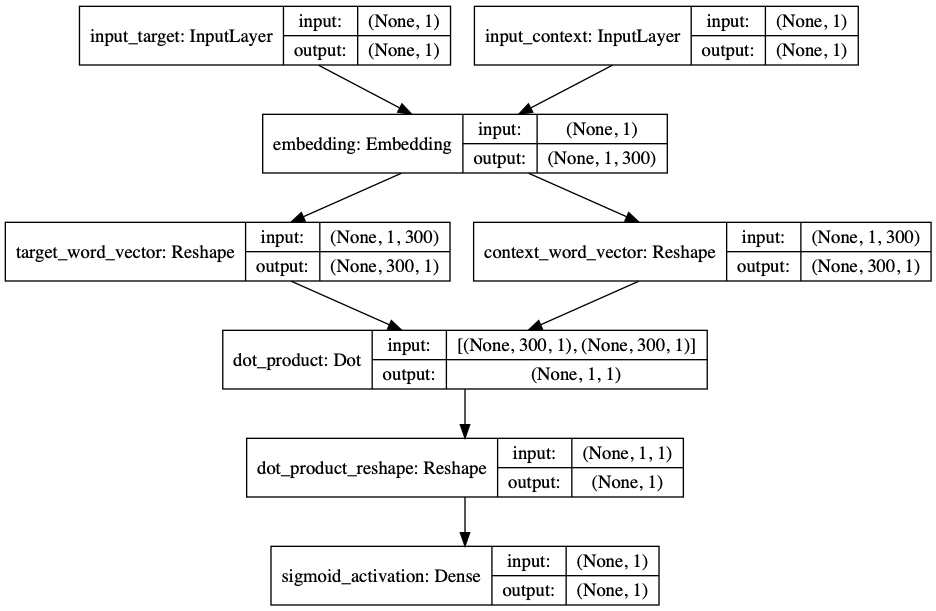

In [11]:
# Visualize model using PyDot and GraphViz
plot_model(w2v_model, show_shapes=True, to_file='word2vec_model.png')

In [12]:
# Load model from file
w2v_model = load_model('word2vec_model.h5')

/Users/triki/.local/share/virtualenvs/code-gd-a4ILK/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [17]:
model_hist = w2v_model.fit(
    list(X_train.T),
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(list(X_test.T), y_test)
)
# TODO: Intermediate UMAP reductions after each epoch?

/Users/triki/.local/share/virtualenvs/code-gd-a4ILK/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 603432 samples, validate on 6096 samples
Epoch 1/5
603432/603432 [==============================] - 148s 245us/step - loss: 0.5310 - accuracy: 0.7444 - val_loss: 0.4194 - val_accuracy: 0.8422
Epoch 2/5
603432/603432 [==============================] - 149s 247us/step - loss: 0.1924 - accuracy: 0.9446 - val_loss: 0.3946 - val_accuracy: 0.8545
Epoch 3/5
603432/603432 [==============================] - 150s 249us/step - loss: 0.0754 - accuracy: 0.9836 - val_loss: 0.4426 - val_accuracy: 0.8419
Epoch 4/5
603432/603432 [==============================] - 150s 248us/step - loss: 0.0598 - accuracy: 0.9870 - val_loss: 0.4849 - val_accuracy: 0.8228
Epoch 5/5
603432/603432 [==============================] - 150s 249us/step - loss: 0.0524 - accuracy: 0.9876 - val_loss: 0.5180 - val_accuracy: 0.8087


In [83]:
# Save model to file
w2v_model.save('word2vec_model.h5')

In [13]:
# Summarize history for accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(model_hist.history['accuracy'])
ax1.plot(model_hist.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['train', 'test'], loc='upper left')

ax2.plot(model_hist.history['loss'])
ax2.plot(model_hist.history['val_loss'])
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['train', 'test'], loc='upper left')
plt.show()

<IPython.core.display.Javascript object>

NameError: name 'model_hist' is not defined

In [14]:
# Evaluate train accuracy
y_train_pred = w2v_model.predict(list(X_train.T))
y_train_acc = roc_auc_score(y_train, y_train_pred)
print(f'Train accuracy: {y_train_acc}')

Train accuracy: 0.9049528063174409


In [15]:
# Evaluate test accuracy
y_test_pred = w2v_model.predict(list(X_test.T))
y_test_acc = roc_auc_score(y_test, y_test_pred)
print(f'Test accuracy: {y_test_acc}')

Test accuracy: 0.9015901418244197


## Analyze word embeddings

In [16]:
# Extract the learned embeddings from the NN
word_embeddings = w2v_model.layers[2].get_weights()[0]

In [17]:
word_embeddings_2d = umap.UMAP().fit_transform(word_embeddings)

<IPython.core.display.Javascript object>


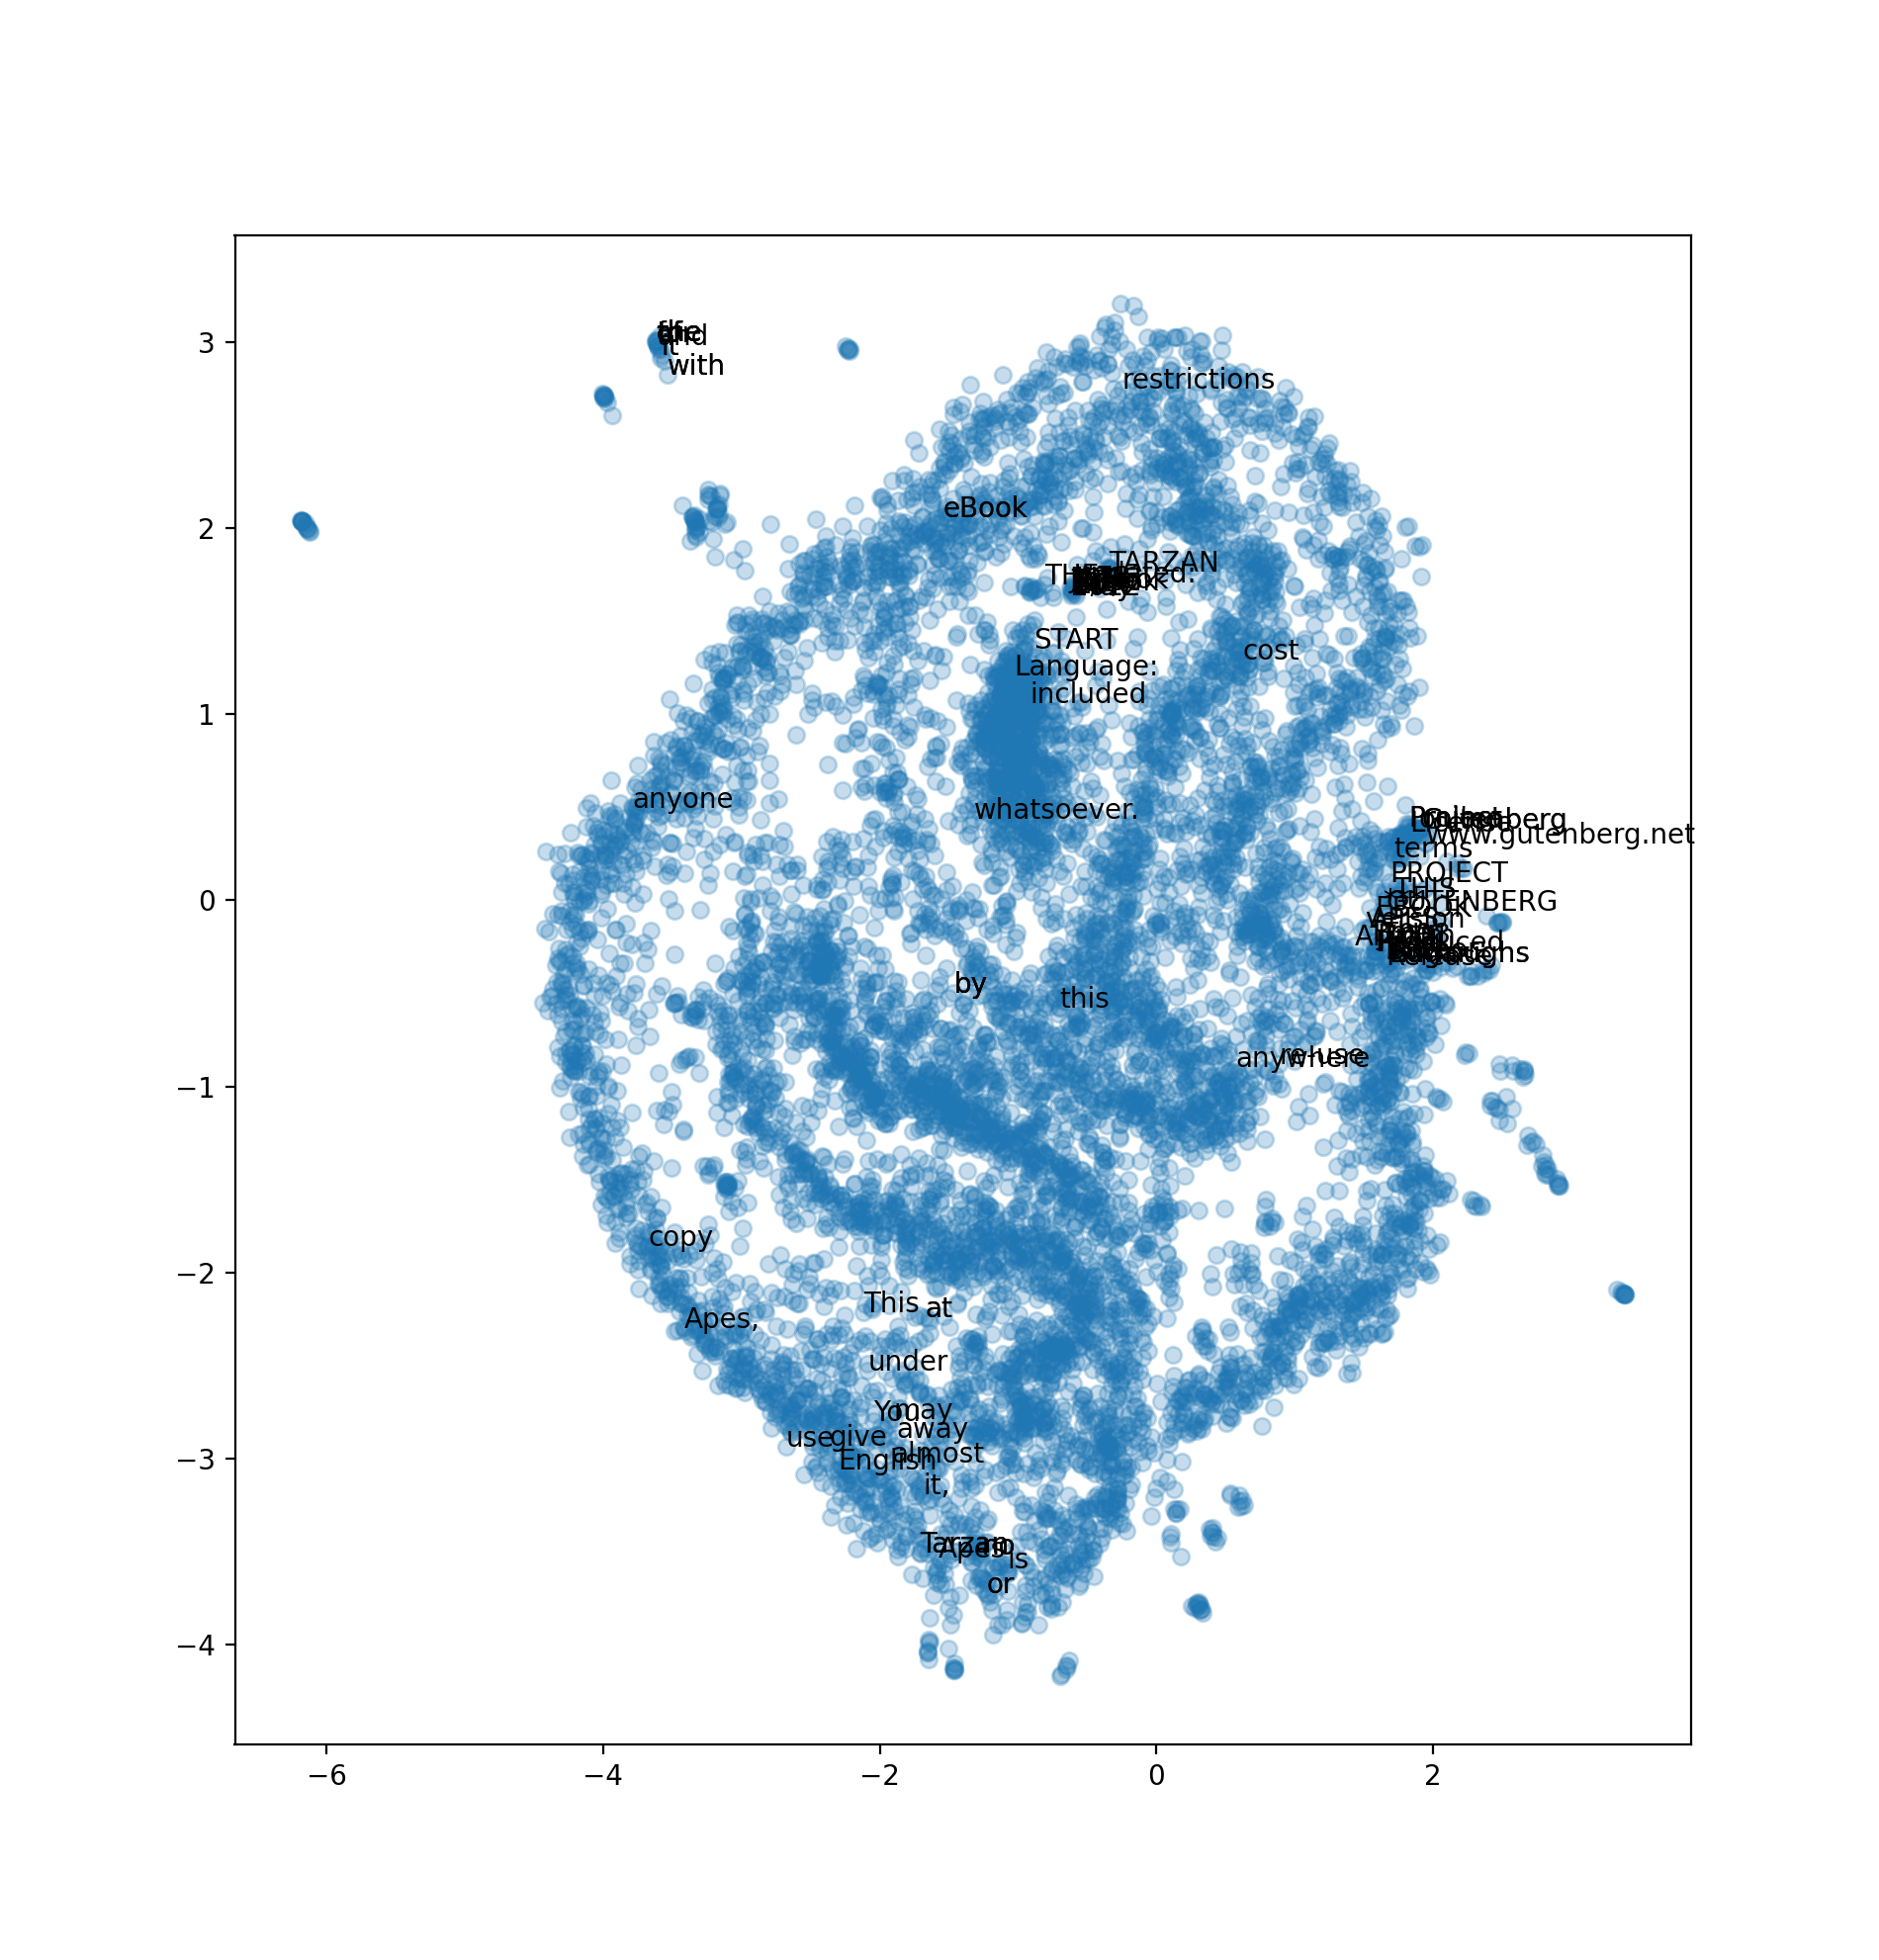

In [18]:
# Plot embedded vectors in 2D
plt.figure(figsize=(10, 10))
plt.scatter(word_embeddings_2d[:, 0], word_embeddings_2d[:, 1], alpha=0.25)

# Annotate
for word_i in book_data[:100]:
    word = rev_book_dictionary[word_i]
    word_vec = word_embeddings_2d[word_i]
    plt.annotate(word, (word_vec[0], word_vec[1]))

In [ ]:
# Tarzan - Man + Woman = Jane?

In [77]:
markers = [fr'${rev_book_dictionary[i]}$' for i in book_data]
markers

['$\ufeffThe$',
 '$Project$',
 '$Gutenberg$',
 '$EBook$',
 '$of$',
 '$Tarzan$',
 '$of$',
 '$the$',
 '$Apes,$',
 '$by$',
 '$Edgar$',
 '$Rice$',
 '$Burroughs$',
 '$This$',
 '$eBook$',
 '$is$',
 '$for$',
 '$the$',
 '$use$',
 '$of$',
 '$anyone$',
 '$anywhere$',
 '$at$',
 '$no$',
 '$cost$',
 '$and$',
 '$with$',
 '$almost$',
 '$no$',
 '$restrictions$',
 '$whatsoever.$',
 '$You$',
 '$may$',
 '$copy$',
 '$it,$',
 '$give$',
 '$it$',
 '$away$',
 '$or$',
 '$re-use$',
 '$it$',
 '$under$',
 '$the$',
 '$terms$',
 '$of$',
 '$the$',
 '$Project$',
 '$Gutenberg$',
 '$License$',
 '$included$',
 '$with$',
 '$this$',
 '$eBook$',
 '$or$',
 '$online$',
 '$at$',
 '$www.gutenberg.net$',
 '$Title:$',
 '$Tarzan$',
 '$of$',
 '$the$',
 '$Apes$',
 '$Author:$',
 '$Edgar$',
 '$Rice$',
 '$Burroughs$',
 '$Release$',
 '$Date:$',
 '$June$',
 '$23,$',
 '$2008$',
 '$[EBook$',
 '$#78]$',
 '$Last$',
 '$updated:$',
 '$May$',
 '$5,$',
 '$2012$',
 '$Language:$',
 '$English$',
 '$***$',
 '$START$',
 '$OF$',
 '$THIS$',
 '$PROJECT